In [1]:
import sys
sys.path.append('../src')

In [2]:
from metrics import calculate_false_alarm, calculate_delay, calculate_precision, compute_metrics
from loading import *
from visualization import *
from features import *
from helpers import *

from matplotlib import pyplot as plt
%matplotlib inline

# Extract metrics for feature according to threshold value

In [3]:
data_path = "../data/"
patient_data = load_patient_seizures(data_path, 2,all_seizures=True, delta=1)

Seizure starts (s):  [[824604.12214844]
 [837451.78589844]]
Seizure ends (s):  [[824690.37769531]
 [837541.65542969]]
Duration (s):  [[86.25554687]
 [89.86953125]]
Sampled frequency (Hz):  512
Start/end [824604.12214844] [824690.37769531]
Start/end [837451.78589844] [837541.65542969]
EEG files:  [['../data/ID02/ID02_229h.mat', '../data/ID02/ID02_230h.mat', '../data/ID02/ID02_231h.mat'], ['../data/ID02/ID02_232h.mat', '../data/ID02/ID02_233h.mat', '../data/ID02/ID02_234h.mat']]
Hour of seizure:  [array([229, 230, 231]), array([232, 233, 234])]
Samples ranges:  [(104510, 148673), (1152914, 1198927)]


In [4]:
eegs = patient_data['eegs']
ranges = patient_data['ranges']
seizure_start_s = patient_data["infos"]["seizure_start"]
seizure_end_s = patient_data["infos"]["seizure_end"] 

In [5]:
max_power_eeg = top_signals(eegs, ranges, top=1, id_seizure = None)

## Convert seizure sample ranges into sliding window ranges

In [6]:
window_size = 128
step_size = 64

In [7]:
indexes = convert_sample_ranges_to_window_ranges(ranges,window_size,step_size,1843200)

# Computing signal energy with window

In [8]:
energy_feature_signals = calculate_feature(eegs, max_power_eeg[0], window_size, step_size, calculate_energy)

## Plotting the obtained signals

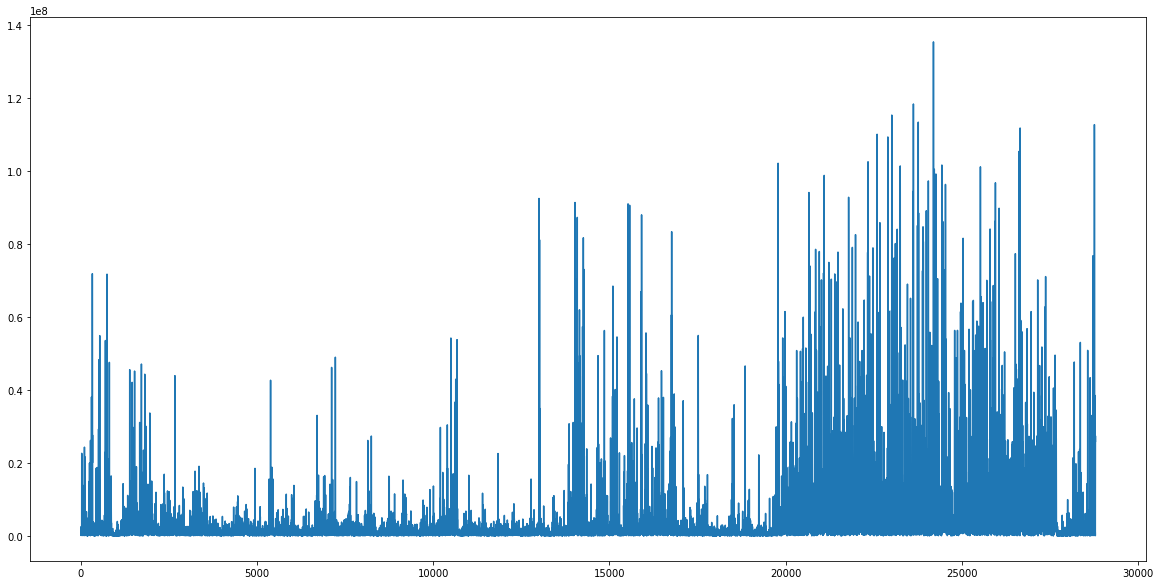

In [9]:
plt.figure(figsize=(20,10))
plt.plot(energy_feature_signals[0][0])

[]

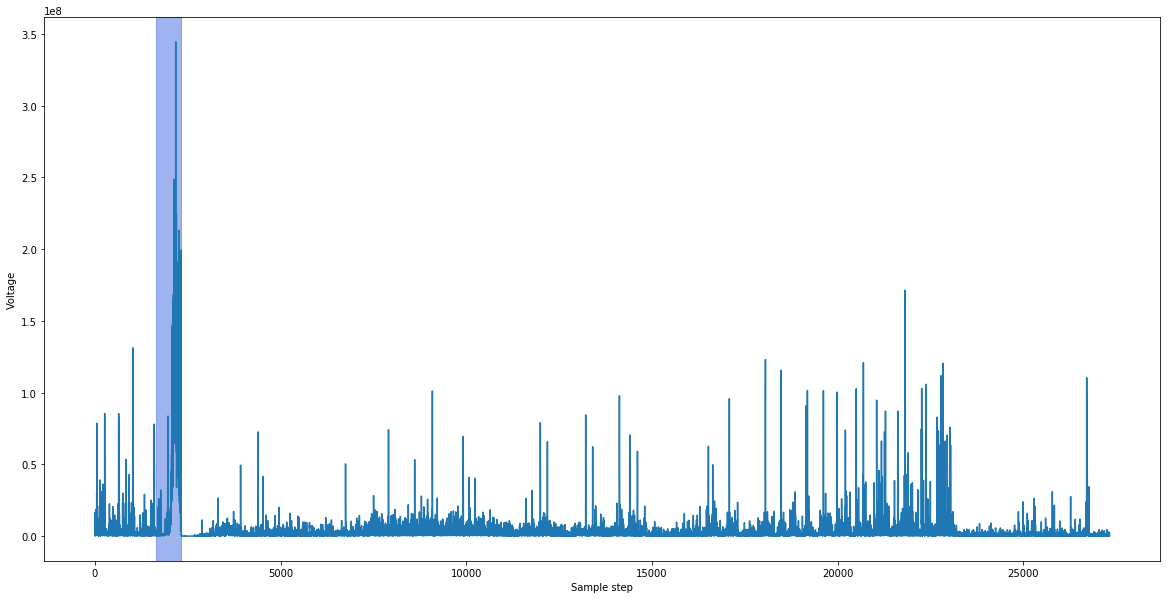

In [10]:
plot_one_signal(energy_feature_signals[0][1] , indexes, 50000, seizure_id=0)

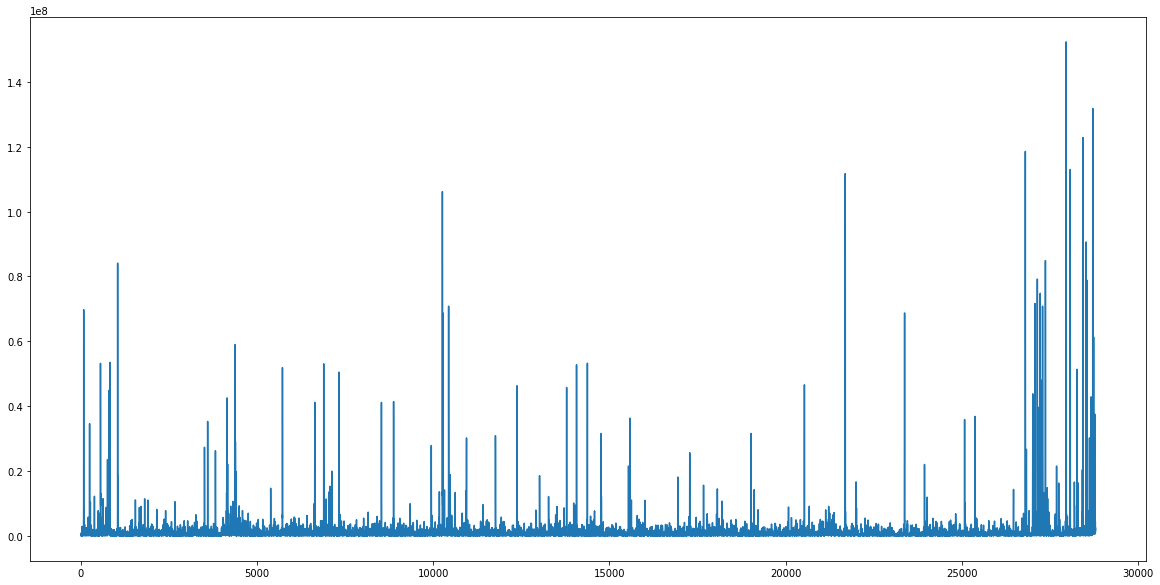

In [11]:
plt.figure(figsize=(20,10))
plt.plot(energy_feature_signals[0][2])

# Merging arrays of multiple files

In [12]:
seizures_window_ranges, seizures_data = merge_seizures_data(energy_feature_signals, indexes)

In [13]:
all_data_window_ranges, all_data = merge_all_data(energy_feature_signals, indexes)

## Plotting the results

### First seizure result

[]

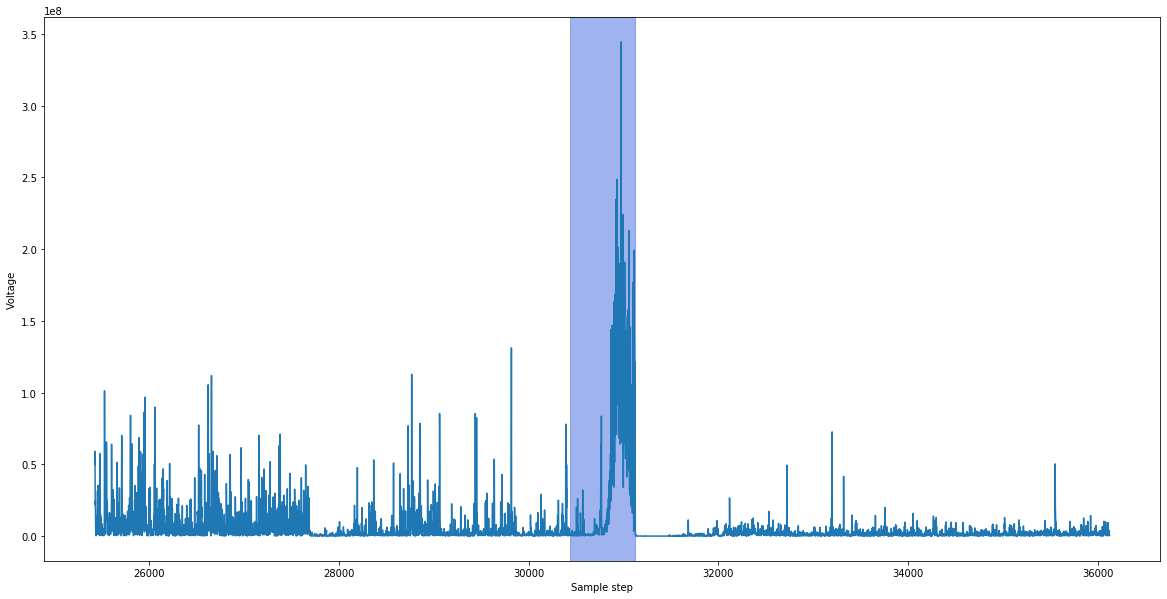

In [14]:
plot_one_signal(seizures_data[0] , seizures_window_ranges, 10000, seizure_id=0)

### Second seizure results

[]

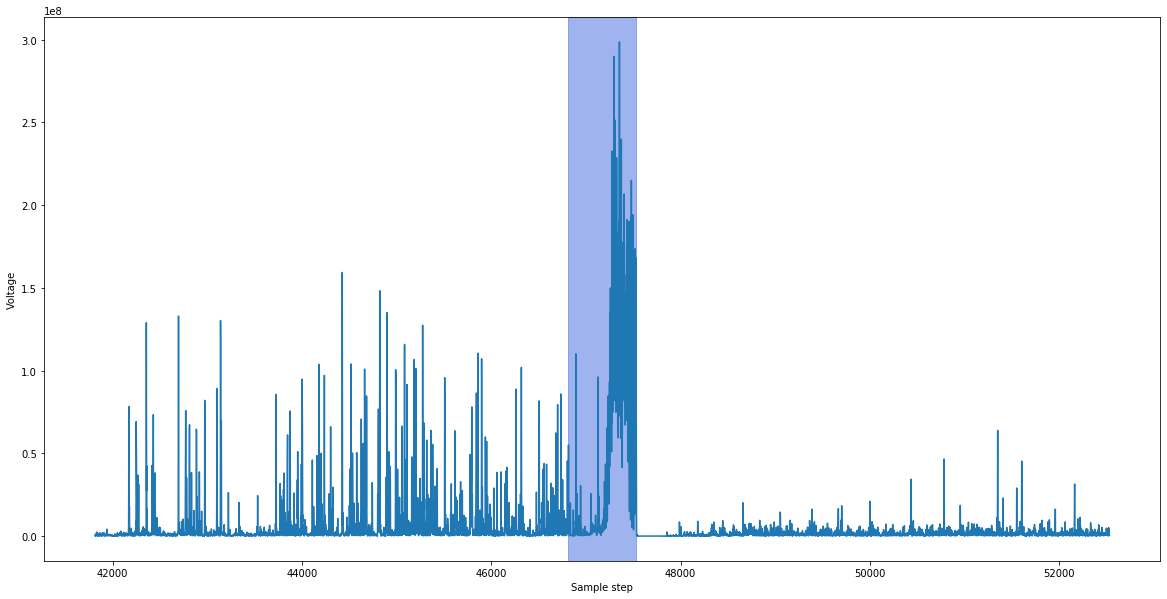

In [15]:
plot_one_signal(seizures_data[1] , seizures_window_ranges, 10000, seizure_id=1)

### All seizures result

[]

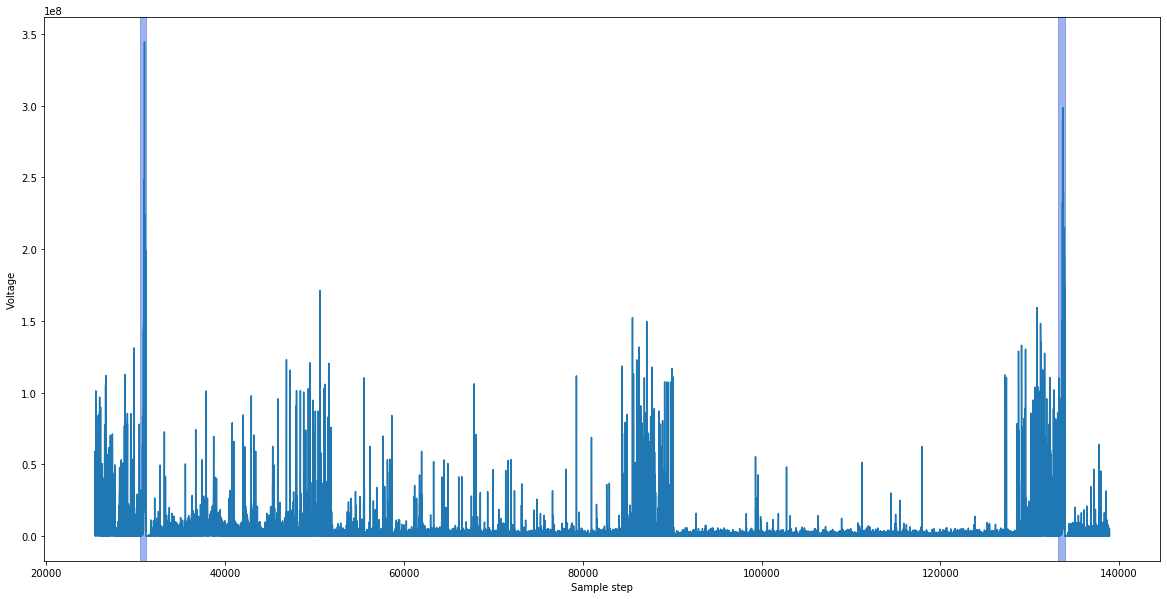

In [16]:
plot_one_signal(all_data , all_data_window_ranges, 10000)

# Plotting real signal and computed energy signal

In [17]:
energy_seizure1_single = energy_feature_signals[0][1]
energy_seizure1_single_scaled = scale_signal(energy_seizure1_single, 128, 64)

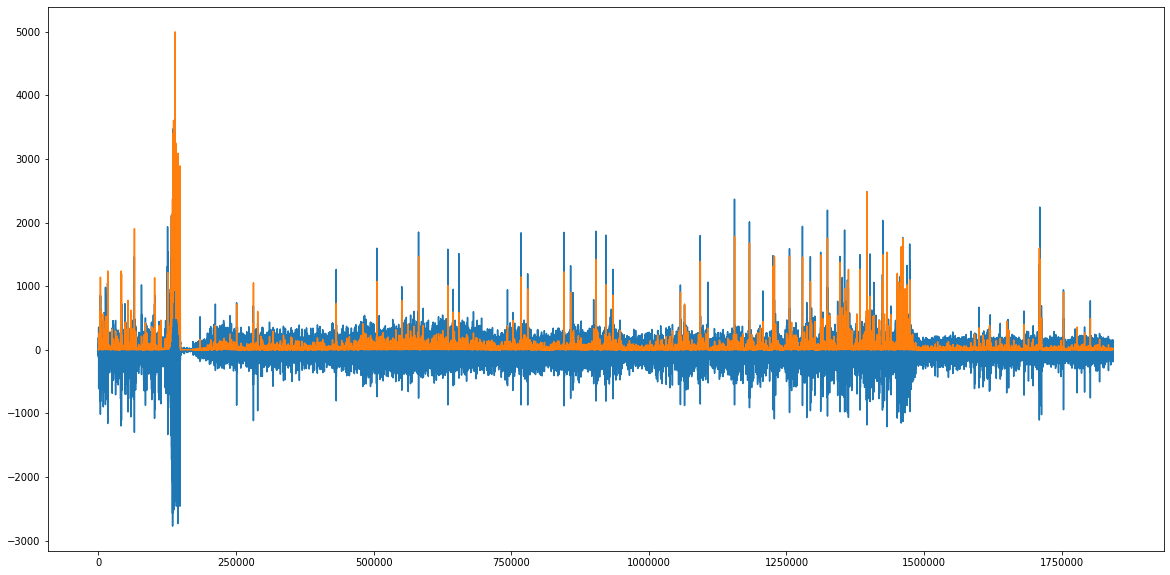

In [18]:
plt.figure(figsize=(20,10))
plt.plot(eegs[0][1][max_power_eeg].T)
plt.plot(energy_seizure1_single_scaled/np.max(energy_seizure1_single_scaled)*5000)

# Calculate metrics according to the threshold value

## Calculate False Alarm

False alarms are calculated by:
* removing the part of the signal where the seizure occurs (we won't find false alarm here)
* Rescaling the signal values between 0 and 1
* Counting the number of elements (1) in the list generated by np.where (a value of this list is equal to one if the corresponding signal value is superior or equal to the threshold

## Calculate Delay

## Calculate precision

# Plotting the functions

In [19]:
thresholds, false_alarms, delays, precisions = compute_metrics(all_data, all_data_window_ranges, window_size, step_size)

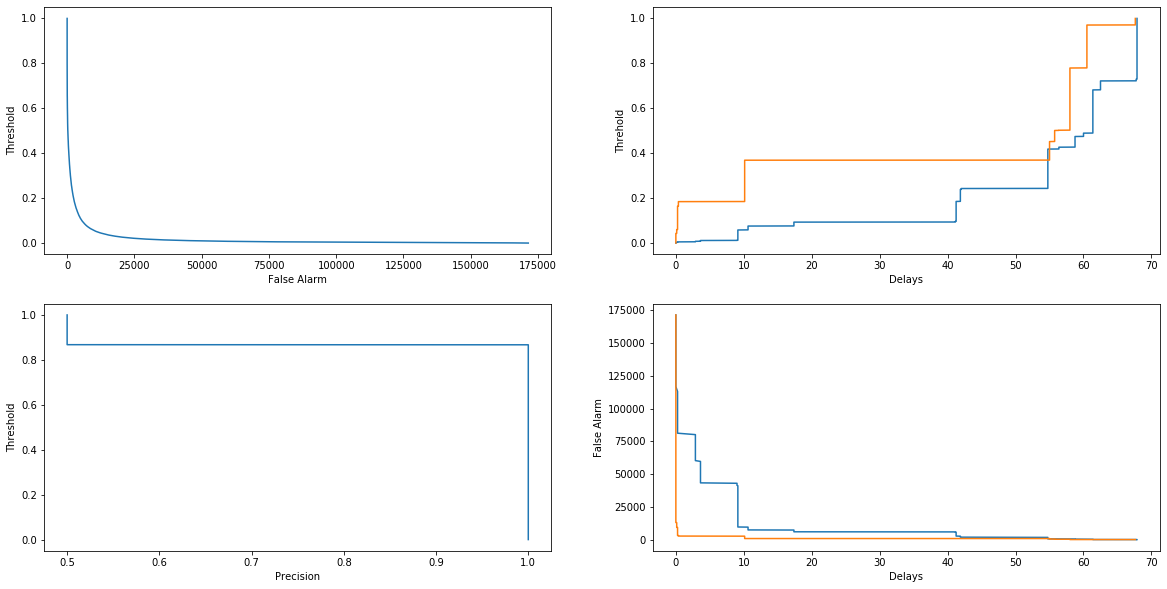

In [20]:
plt_all_metrics = plot_metrics(thresholds, false_alarms, delays, precisions)

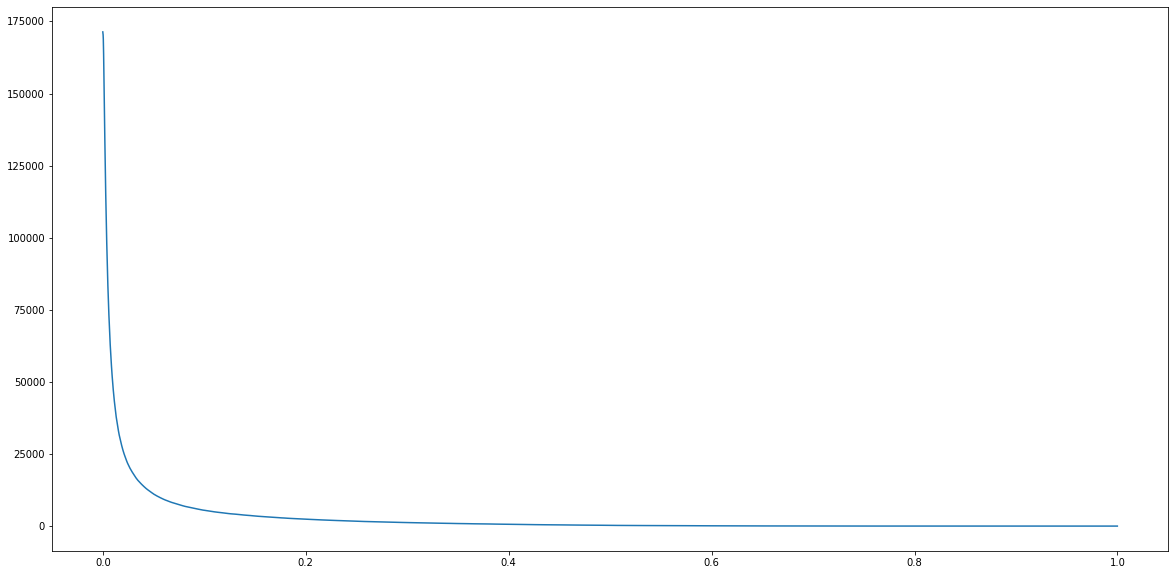

In [21]:
plt.figure(figsize=(20,10))
plt.plot(thresholds, false_alarms)

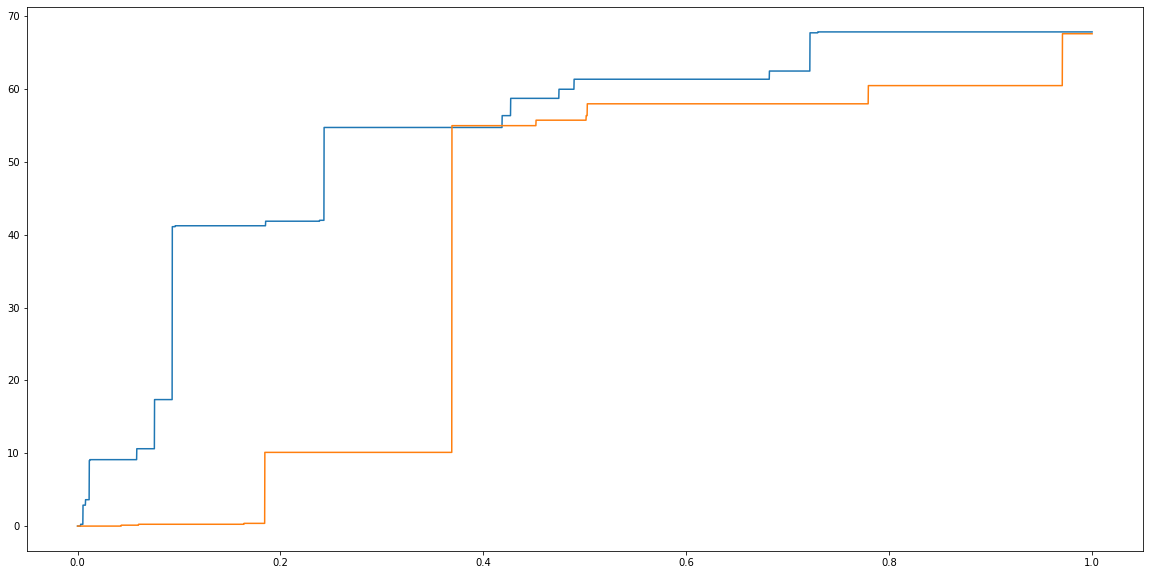

In [22]:
plt.figure(figsize=(20,10))
for i in range(len(delays[0])):
    plt.plot(thresholds, [pt[i] for pt in delays],label = 'seizure %s'%i)
plt.show()

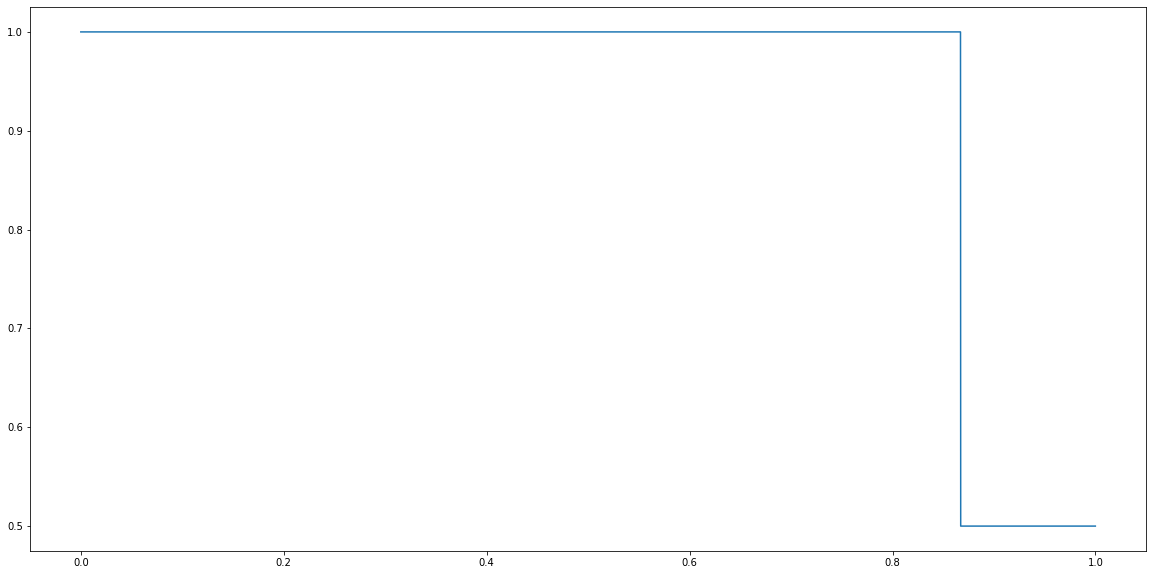

In [23]:
plt.figure(figsize=(20,10))
plt.plot(thresholds, precisions)
plt.show()

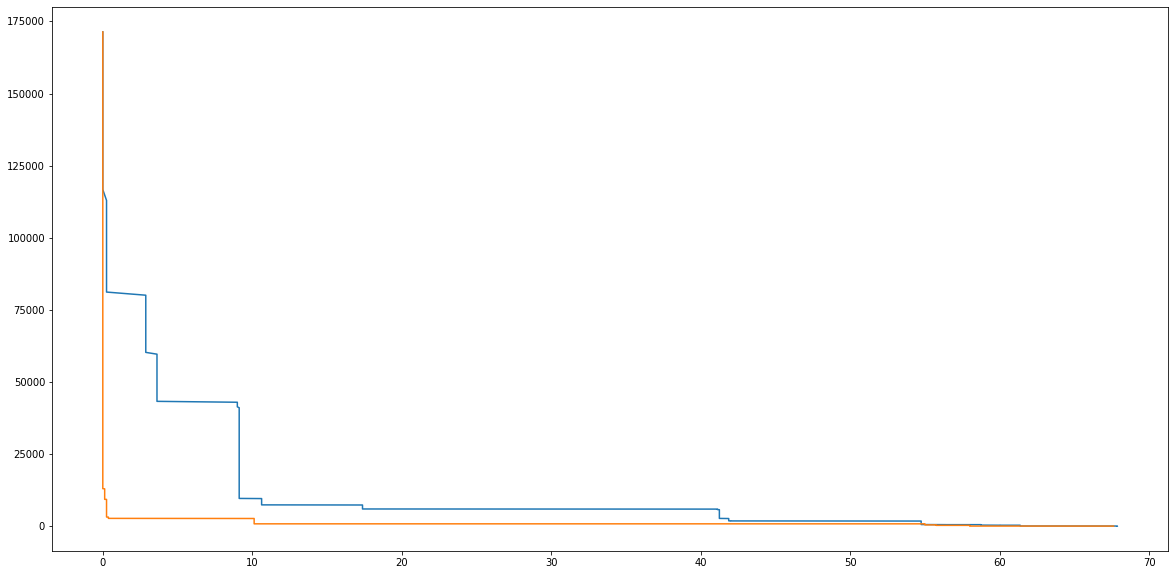

In [24]:
plt.figure(figsize=(20,10))
for i in range(len(delays[0])):
    plt.plot([pt[i] for pt in delays], false_alarms, label = 'seizure %s'%i)
plt.show()

In [25]:
w1, w2, w3 = (1/25000,1/500,1)
final_cost_function = []
for i in range(len(delays[1])):
    final_cost_function.append(w1*np.array(false_alarms) - w2*np.array([pt[i] for pt in delays]) + w3*np.array(precisions))

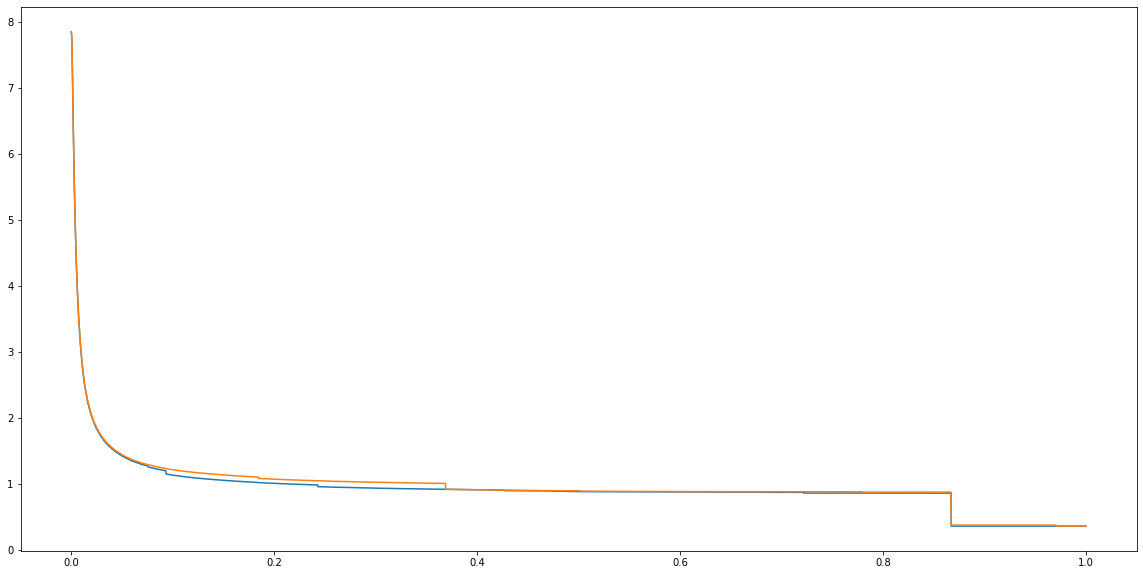

In [26]:
plt.figure(figsize=(20,10))
for final_cost in final_cost_function:
    plt.plot(thresholds, final_cost)